# IV - 0D computations

In [8]:
import sys
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt#
from matplotlib import *
import csv

In [9]:
Temp=1200.0
T_str='1200'
n_points = 10000    #iterations


# Create a Cantera Solution object
gas = ct.Solution('BFER_methane.yaml', 'CH4_BFER_mix')
gas.TPX = Temp, ct.one_atm, {'CH4': 1, 'O2': 2, 'N2': 7.52}
Ini_Temp=gas.T
# Get properties
density = gas.density
viscosity = gas.viscosity
thermal_conductivity = gas.thermal_conductivity
kinematic_viscosity = viscosity / density  # m²/s
cp = gas.cp

species_names = gas.species_names
molar_masses = gas.molecular_weights/1000  # Molar masses in kg/mol
diff_coeffs = gas.mix_diff_coeffs  # m²/s
mass_fractions = gas.Y
mol_frac = gas.X

print(gas())
print("-------------------------------------------------------")
print(f"Density (rho_0):\t {density:.4e} kg/m³")
print(f"Kine Visc (nu_0):\t {kinematic_viscosity:.4e} m²/s")
print(f"cp: \t\t\t{cp:.2f} ")
print(f"Therm Cond:(lambda)\t {thermal_conductivity:.4e} W/m/K\n\n")

for i, specie in enumerate(species_names):
    print(f"Species: {specie}")
    print(f"Molar Mass: {molar_masses[i]:.4f}")  # Print molar mass in SI units
    print(f"Mass Fraction: {mass_fractions[i]:.6f}")
    print(f"Mole Fraction: {mol_frac[i]:.6f}")
    print(f"Mix Diffusion Coefficient: {diff_coeffs[i]:.4e}")
    print("")



  CH4_BFER_mix:

       temperature   1200 K
          pressure   1.0133e+05 Pa
           density   0.28063 kg/m^3
  mean mol. weight   27.633 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        8.6193e+05        2.3818e+07  J
   internal energy        5.0087e+05        1.3841e+07  J
           entropy            8914.2        2.4633e+05  J/K
    Gibbs function       -9.8351e+06       -2.7178e+08  J
 heat capacity c_p            1397.3             38611  J/K
 heat capacity c_v            1096.4             30296  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.22014           0.19011           -28.747
               CH4          0.055187          0.095057           -35.961
                N2           0.72467           0.71483          

In [10]:
gas.n_species

6

In [11]:
# Reactor and environment
r = ct.IdealGasReactor(gas)             ##r = ct.Reactor(gas)
env = ct.Reservoir(gas)                 ##sim = ct.ReactorNet([r])

# Wall
w = ct.Wall(r, env)
w.expansion_rate_coeff = 1.0e6  # set expansion parameter. dV/dt = KA(P_1 - P_2)
w.area = 1.0

# Prepare the simulation with a ReactorNet object
sim = ct.ReactorNet([r])
time = 0
HR = []
temperature = []
mfrac = []
auto_ignitions = []
species_names = ['O2', 'H2O','CH4','CO', 'CO2', 'N2']
times = np.zeros(n_points)
data = np.zeros((n_points, len(species_names) + 3))  # +1 for temperature
header = 'Iteration,Time (s),Temperature,' + ','.join(species_names)

#print(('%10s %10s %10s %14s' % ('t [s]', 'T [K]', 'vol [m3]', 'u [J/kg]')))
for n in range(n_points):
    time += 8.e-8
    sim.advance(time)
    times[n] = time  # time in s
    data[n, 0] = n + 1  # iteration number
    data[n, 1] = time  # time in s
    data[n, 2] = r.T  # set the temperature in the third column
    data[n, 3:] = r.thermo[species_names].X  # set the molar fractions in the remaining columns
    temperature.append(r.T)
    mfrac.append(r.thermo.Y)
    HR.append(- np.dot(gas.net_production_rates, gas.partial_molar_enthalpies)) #Calculates the heat release rate using the net production rates of species and their partial molar enthalpies.
  
data_with_iteration = np.column_stack((data[:, :2], data[:, 2:]))   
np.savetxt('Results/CANTERA_BFER_species_molar_fractions'+T_str+'.csv', data_with_iteration, delimiter=',', header=header, comments='')

In [12]:
gas()


  CH4_BFER_mix:

       temperature   2765.1 K
          pressure   1.0133e+05 Pa
           density   0.11913 kg/m^3
  mean mol. weight   27.03 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        8.6193e+05        2.3299e+07  J
   internal energy             11400        3.0815e+05  J
           entropy             10318         2.789e+05  J/K
    Gibbs function       -2.7669e+07        -7.479e+08  J
 heat capacity c_p            1543.3             41717  J/K
 heat capacity c_v            1235.7             33402  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2          0.025831          0.021821           -33.793
               H2O           0.12394           0.18597           -41.189
               CH4       -1.5087e-14        -2.542e-14         

In [13]:
auto_ignition = times[HR.index(max(HR))] #Finds the ignition time (time of maximum heat release rate) by locating the index in the HR list where the maximum value occurs and then finding the corresponding time from the time list
print('For T = ' + str(Ini_Temp) + ', Autoignition time = ' + str(auto_ignition) + ' s')
# Posterity
FinalTemp = temperature[n_points - 1]
auto_ignitions.append(auto_ignition)

For T = 1200.0, Autoignition time = 0.00016536000000000583 s


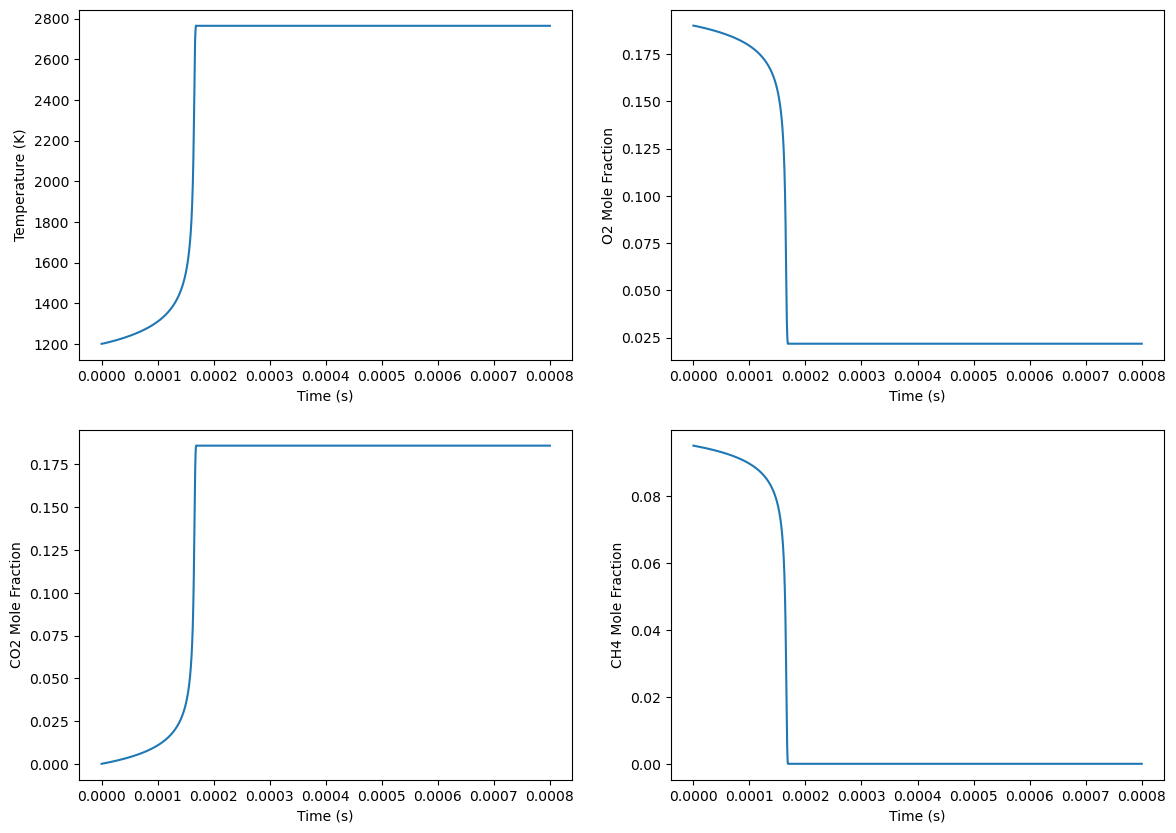

In [14]:
#0          1           2       3   4       5   6   7   8
#Iteration,Time (s),Temperature, O2, H2O, CH4, CO, CO2, N2

# Define your list of species
species_to_plot = ['Temperature (K)', 'O2 Mole Fraction', 'CO2 Mole Fraction', 'CH4 Mole Fraction']

# Create a subplot grid dynamically based on the number of species
num_species = len(species_to_plot)
num_rows = int(np.ceil(num_species / 2))
num_cols = min(2, num_species)

# Set the figure size
plt.figure(figsize=(14, 10))

# Loop through each species and create a subplot
for i, species in enumerate(species_to_plot):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.plot(times, data[:, i + 2])
    plt.xlabel('Time (s)')
    plt.ylabel(species)

# Adjust subplot layout
#plt.tight_layout()

plt.show()